In [1]:
#Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc,precision_score, recall_score
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#from scipy.stats import chi2_contingency
import pickle
import os
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report


#Modulos
import PredictionVF as pr
import aws_utils as au

In [2]:
REGION = 'us-east-1'
BUCKET_NAME = 'modelo-pd-2' 
FOLDER = 'modelos' 

In [3]:
#Cargamos el dataset
loan_data = pd.read_csv('hmeq.csv',sep=",")
loan_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
#Controlamos si las variables tienen mas del 70% con nulos
na_values = loan_data.isnull().mean()
na_values[na_values>0.7]

Series([], dtype: float64)

In [5]:
# Separamos el target de las variables
X = loan_data.drop('BAD', axis = 1)
#definimos el target
y = loan_data['BAD']
#Dividimos el dataset en testeo y train, usamos para entrenar el 80% y el 20% para testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#X_train, X_test = X_train.copy(), X_test.copy()

In [6]:
#Dividimos las variables categoricas de las numericas
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [32]:
# Calculamos la matriz de correlación de Pearson
correlation_matrix = X_train_num.corr(method='pearson')
print(correlation_matrix)

             LOAN   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
LOAN     1.000000  0.215135  0.323422  0.111133 -0.000850 -0.031777  0.090165   
MORTDUE  0.215135  1.000000  0.871692 -0.088285 -0.048923 -0.001182  0.146135   
VALUE    0.323422  0.871692  1.000000  0.006733 -0.044227 -0.011572  0.176028   
YOJ      0.111133 -0.088285  0.006733  1.000000 -0.058645  0.048073  0.195823   
DEROG   -0.000850 -0.048923 -0.044227 -0.058645  1.000000  0.201555 -0.084036   
DELINQ  -0.031777 -0.001182 -0.011572  0.048073  0.201555  1.000000  0.023732   
CLAGE    0.090165  0.146135  0.176028  0.195823 -0.084036  0.023732  1.000000   
NINQ     0.049083  0.027545 -0.001404 -0.075249  0.178390  0.055445 -0.113010   
CLNO     0.069648  0.316789  0.263231  0.031664  0.063091  0.166859  0.236212   
DEBTINC  0.070871  0.143106  0.125129 -0.049710  0.020302  0.038468 -0.044667   

             NINQ      CLNO   DEBTINC  
LOAN     0.049083  0.069648  0.070871  
MORTDUE  0.027545  0.316789 

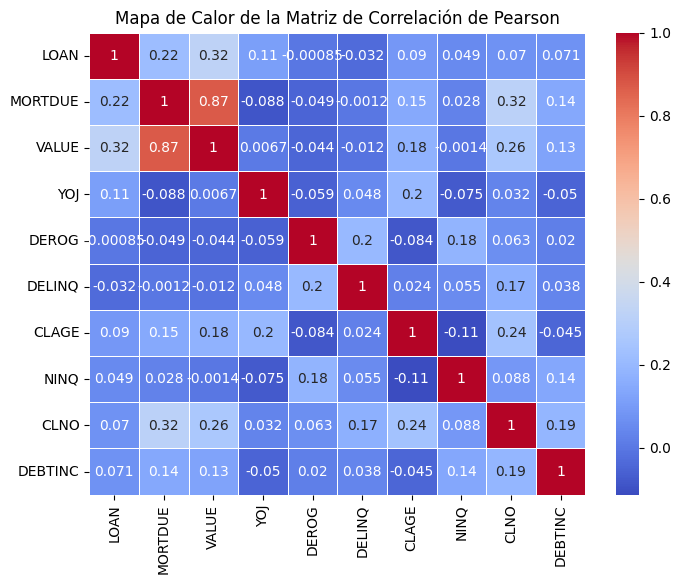

In [31]:
# Creamos un mapa de calor, se detecta alta correlacion entre value y mortdue. 
#Por tal motivo se procede a descartar una de las variables posteriormente
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Mapa de Calor de la Matriz de Correlación de Pearson')
plt.show()

In [7]:
# creamos la funcion para converir a dummy las variables categoricas
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [8]:
# Transformamos las variables categoricas en dummy
X_train = dummy_creation(X_train, ['REASON', 'JOB'])#'verification_status',
X_test = dummy_creation(X_test, ['REASON', 'JOB'])

In [9]:
#creamos funcion para completar los nulos con ceros de determinadas columnas
def fill_null_with_zeros(dataframe, columns_to_fill):
    for column in columns_to_fill:
        dataframe[column].fillna(0, inplace=True)
    return dataframe

In [10]:
#Definimos las columnas a completar con cero
columns_to_fill_with_zeros = ['DEROG', 'DEBTINC','DELINQ','NINQ','CLNO','MORTDUE','YOJ','CLAGE']

In [11]:
#completamso con cero las columnas definidas anteriormente
X_train=fill_null_with_zeros(X_train, columns_to_fill_with_zeros)
X_test=fill_null_with_zeros(X_test, columns_to_fill_with_zeros)

In [12]:
#creamos funcion para completar con la media los valores nulos
def fill_null_with_mean(dataframe, columns_to_fill):
    for column in columns_to_fill:
        mean = dataframe[column].mean()
        dataframe[column].fillna(mean, inplace=True)
    return dataframe

In [13]:
#Definimos las columnas a completar los nulos con la media
columns_to_fill_with_mean = ['LOAN', 'VALUE']
X_train = fill_null_with_mean(X_train, columns_to_fill_with_mean)
X_test = fill_null_with_mean(X_test, columns_to_fill_with_mean)

In [14]:
#Definimos las columnas a standarizar (se descarto mortdue por correlacion con value)
columns_to_standardize = ['LOAN',  'VALUE','CLAGE']#'MORTDUE'

# Creamos un objeto StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Aplicamos la estandarización a las columnas seleccionadas
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

In [15]:
# Definimos el nombre del archivo
file_name = 'scaler_model.pkl'
# Carpeta de destino
folder_name = 'modelos'
# Combinamo la carpeta de destino con el nombre del archivo
file_path = os.path.join(folder_name, file_name)
# Guardamos el modelo en un archivo pickle en la carpeta especificada
with open(file_path, 'wb') as file:
    pickle.dump(scaler, file)

In [16]:
# Utiliza el método .drop() para eliminar las columnas con valores nulos
columnas_con_nulos = X_train.columns[X_train.isnull().any()]
X_train_sin_nulos = X_train.drop(columns=columnas_con_nulos)
X_test_sin_nulos = X_test.drop(columns=columnas_con_nulos)
#vamos a eliminar las filas con las columnas con nulos (previamente se detecto que los registros tenian variables vacias)
rows_with_nulls = X_train[columnas_con_nulos].isnull().any(axis=1)
X_train_with_nulls = X_train[rows_with_nulls]

In [17]:
#Eliminamos las variables de mortdue y reason
X_train_sin_nulos=X_train_sin_nulos.drop(columns=['MORTDUE','REASON:HomeImp'])
X_test_sin_nulos=X_test_sin_nulos.drop(columns=['MORTDUE','REASON:HomeImp'])

In [29]:
# Modelo de regresión logística
model = LogisticRegression()
# Entrenamos el modelo en los datos de entrenamiento
result=model.fit(X_train_sin_nulos, y_train)
# Realizamos predicciones en los datos de prueba
y_pred = result.predict(X_test_sin_nulos)
# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo: {accuracy:.2f}')

Accuracy del modelo: 0.86


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# Parametros del modelo (betas)
coefficients = result.coef_
intercept = result.intercept_

print("Coeficientes (Betas):", coefficients)
print("Intercepto (Beta0):", intercept)

Coeficientes (Betas): [[-9.43267902e-02  1.08146061e-01 -5.63129724e-03  5.36697814e-01
   6.98874582e-01 -5.44363868e-01  1.58074290e-01  7.04979032e-04
  -5.77036238e-02 -2.42534974e-01  6.76996963e-01  2.98494149e-01
   1.04187674e+00  6.09624940e-01  2.26230840e+00  1.32420837e+00]]
Intercepto (Beta0): [-1.51916084]


In [25]:
# Nombre del archivo
file_name = 'modelo.pkl'
# Combinamos la carpeta de destino con el nombre del archivo
file_path = os.path.join(folder_name, file_name)
# Guardamos el modelo en un archivo pickle en la carpeta especificada
with open(file_path, 'wb') as file:
    pickle.dump(result, file)

In [26]:
# Realizamos predicciones con el modelo
y_pred_probs = result.predict(X_test_sin_nulos)
# Convertimos probabilidades en etiquetas de clase, umbral de 0.5
y_pred_labels = (y_pred_probs > 0.5).astype(int)
# Calculamos ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)
# Calculamos precisión
precision = precision_score(y_test, y_pred_labels)
# Calculamos recall
recall = recall_score(y_test, y_pred_labels)
# Calculamos matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_labels)
# Resultados
print("ROC AUC:", roc_auc)
print("Precisión:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)

ROC AUC: 0.7116959991543786
Precisión: 0.7676056338028169
Recall: 0.4579831932773109
Matriz de Confusión:
 [[921  33]
 [129 109]]


Testeo predict

In [67]:
# Ruta a la carpeta donde se encuentran los archivos
folder_path = 'C:/Users/jsrie/Downloads/model-pd-2/modelos'

def fetch_pickle(file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'rb') as f:
        fetched_object = pickle.load(f)
    return fetched_object


In [69]:
###Prueba FINAL:FUNCIONAAAA
#from sklearn.preprocessing import StandardScaler
#import numpy as np

def predict(sample: list) -> dict:
    model =fetch_pickle('modelo.pkl')# fetch_pickle(BUCKET_NAME, FOLDER, 'modelo.pkl')

    print(f'Received sample: {sample}')
    column_order = ['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON:DebtCon', 'JOB:Mgr', 'JOB:Office','JOB:Other', 'JOB:ProfExe', 'JOB:Sales', 'JOB:Self']
    # Organizamos'sample' en el mismo orden que las columnas de entrenamiento
    sample_ordered = [sample[column_order.index(col)] for col in column_order]
    # Definimos las variables a las que deseas aplicar el StandardScaler
    features_to_scale = ['LOAN', 'VALUE', 'CLAGE']
    # Definimos los índices de las variables categóricas en 'sample'
    categorical_indices = [column_order.index(col) for col in column_order if col not in features_to_scale]
    # Separamos las varibles categoricas de las numericas
    categorical_variables = [sample[i] for i in categorical_indices]
    continuous_variables = [sample[i] for i in range(len(sample)) if i not in categorical_indices]
    # Aplicamos standar scalar a las varibles continuas
    scaler =fetch_pickle('scaler_model.pkl')# fetch_pickle(BUCKET_NAME, FOLDER, 'scaler_model.pkl')
    scaled_continuous_variables = scaler.transform([continuous_variables])
    categorical_variables_2d = np.array(categorical_variables).reshape(1, -1)
    # Unificamos el input transformado
    input_data = np.concatenate([categorical_variables_2d, scaled_continuous_variables], axis=1)
    # Definimos el nuevo orden de las columnas
    new_order = [ 13, 14, 0, 1, 2, 15, 3, 4, 5, 6, 7,8, 9, 10, 11,12]
    # Reorganizamos las columnas en el nuevo orden
    input_data_fin = input_data[:, new_order]
    # Realizamos la predicción de regresión logística
    predicted_probabilities = model.predict_proba(input_data_fin)[:, 1]
    # Clase predicha
    predicted_class = 1 if predicted_probabilities >= 0.5 else 0
    predicted_result = {
        'sample': sample,
        'predicted_class': predicted_class,
        'predicted_probabilities': predicted_probabilities
    }

    return predicted_result

In [114]:
sample=[10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
result = predict(sample)
print(result)


Received sample: [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'sample': [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'predicted_class': 0, 'predicted_probabilities': array([0.11035269])}


In [123]:
sample=[10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

pr.predict(sample)

Loading modelo.pkl from local
Received sample: [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Loading scaler_model.pkl from local


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'sample': [10700,
  64838,
  9.0,
  0.0,
  0.0,
  95.039168,
  2.0,
  34.0,
  40.396233444,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0],
 'predicted_class': 0,
 'predicted_probabilities': array([0.11035269])}

In [126]:
import requests as req
req.get('http://localhost:5000/pagador?LOAN=5000&VALUE=10000&YOJ=2&DEROG=0&DELINQ=0&CLAGE=30&NINQ=1&CLNO=10&DEBTINC=35&REASON:DebtCon=1&JOB:Mgr=0&JOB:Office=1&JOB:Other=0&JOB:ProfExe=0&JOB:Sales=0&JOB:Self=0').json()

{'prediction': 0,
 'probability_default': 0.07079645520520722,
 'result': 'No Default',
 'sample': [5000.0,
  10000.0,
  2.0,
  0.0,
  0.0,
  30.0,
  1.0,
  10.0,
  35.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [ ]:
'http://ec2-3-87-43-131.compute-1.amazonaws.com:5000/pagador?LOAN=5000&VALUE=10000&YOJ=2&DEROG=0&DELINQ=0&CLAGE=30&NINQ=1&CLNO=10&DEBTINC=35&REASON:DebtCon=1&JOB:Mgr=0&JOB:Office=1&JOB:Other=0&JOB:ProfExe=0&JOB:Sales=0&JOB:Self=0'